In [15]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from pydantic import BaseModel, Field
import operator

In [16]:
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

In [17]:
class EvaluationSchema(BaseModel) :
    feedback :str = Field(description="detailed feedback on the essay")
    score: int = Field(description="score out of 10 for the essay", ge=0, le=10)

In [18]:
model = ChatGoogleGenerativeAI(
    model= "gemini-2.5-flash",
    temperature=1.0,
    max_retries=2,
    google_api_key=api_key,
)
structured_model = model.with_structured_output(EvaluationSchema)

In [19]:
class EssayState(TypedDict):
    essay_text : str
    cot_feedback : str
    doa_feedback : str
    lang_feedback : str
    final_feedback : str
    individual_score : Annotated[list[int], operator.add]
    final_score : float

In [20]:
def cot_feedback(State: EssayState):
    prompt = f"""You are an expert essay reviewer. 
    Given the following essay, provide detailed feedback on its content, structure, and coherence and a score on a scale of 1 to 10.
    Essay: {State['essay_text']}
   """
    response = structured_model.invoke([prompt])
    return {"cot_feedback": response.feedback, "individual_score": [response.score]}

def doa_feedback(State: EssayState):
    prompt = f"""You are an expert essay reviewer. 
    Given the following essay, provide detailed feedback on its depth of analysis and originality and a score on a scale of 1 to 10.
    Essay: {State['essay_text']}
   """
    response = structured_model.invoke([prompt])
    return {"doa_feedback": response.feedback, "individual_score": [response.score]}

def lang_feedback(State: EssayState):
    prompt = f"""You are an expert essay reviewer. 
    Given the following essay, provide detailed feedback on its language, grammar, and style and a score on a scale of 1 to 10.
    Essay: {State['essay_text']}
   """
    response = structured_model.invoke([prompt])
    return {"lang_feedback": response.feedback, "individual_score": [response.score]}

def final_feedback(State: EssayState):
    prompt = f""" Based on the following feedbacks, provide a comprehensive final feedback for the essay.
    Content & Structure Feedback: {State['cot_feedback']}
    Depth of Analysis & Originality Feedback: {State['doa_feedback']}
    Language & Style Feedback: {State['lang_feedback']}
"""
    overal_feedback = model.invoke([prompt]).content
    final_score = sum(State['individual_score']) / len(State['individual_score'])
    return {"final_feedback": overal_feedback, "final_score": final_score}





In [21]:
graph = StateGraph(EssayState)

# add nodes
graph.add_node("cot_feedback",  cot_feedback)
graph.add_node("doa_feedback",  doa_feedback)
graph.add_node("lang_feedback",  lang_feedback)
graph.add_node("final_feedback", final_feedback)

# add edges
graph.add_edge(START, "cot_feedback")
graph.add_edge(START, "doa_feedback")
graph.add_edge(START, "lang_feedback")
graph.add_edge("cot_feedback", "final_feedback")
graph.add_edge("doa_feedback", "final_feedback")
graph.add_edge("lang_feedback", "final_feedback")
graph.add_edge("final_feedback", END)

# compile graph 
workflow = graph.compile()

In [22]:
initial_state ={
    "essay_text" : """japanses is very hardest language. there are many level like n5, n4. there are kanji katakana and hiragana. """
}
final_state = workflow.invoke(initial_state)
print(final_state)

{'essay_text': 'japanses is very hardest language. there are many level like n5, n4. there are kanji katakana and hiragana. ', 'cot_feedback': "The essay is extremely underdeveloped and lacks significant detail in its content. While it touches upon the difficulty of the Japanese language, JLPT levels (N5, N4), and its writing systems (Kanji, Katakana, Hiragana), it provides no elaboration or examples for any of these points. To improve, each statement needs to be expanded upon with specific reasons, explanations, or illustrative examples. \n\nStructurally, the essay is virtually non-existent. It consists of three very short, disconnected sentences with no introduction, body paragraphs, or conclusion. There are no clear topic sentences or transitional phrases to guide the reader. \n\nIn terms of coherence, the sentences do not flow logically or build upon each other to form a cohesive argument or description. The lack of development and connection between ideas makes the essay feel frag

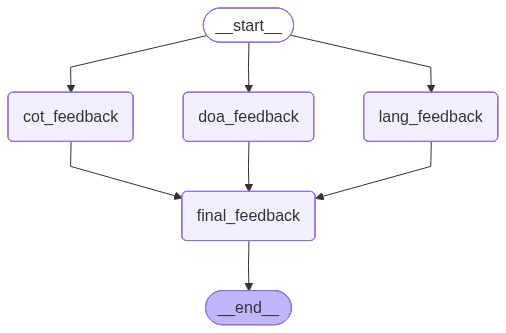

In [23]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())